<a href="https://colab.research.google.com/github/cbadenes/curso-pln/blob/main/notebooks/02_naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de Reseñas de Restaurantes usando Naive Bayes

Este notebook demuestra cómo implementar un clasificador Naive Bayes para categorizar reseñas de restaurantes según su valoración.

## 1. Configuración del Entorno

In [6]:
# Importar bibliotecas necesarias
import json
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import requests
import matplotlib.pyplot as plt

## 2. Cargar y Preparar los Datos

In [27]:
# Cargar datos desde GitHub
url = "https://raw.githubusercontent.com/cbadenes/curso-pln/main/datasets/valoraciones_restaurante.json"
response = requests.get(url)
data = response.json()
df = pd.DataFrame(data['reviews'])

print("Muestra de reseñas:")
print(df.head())

print("\nDistribución de valoraciones:")
print(df['rating'].value_counts().sort_index())

Muestra de reseñas:
   id  rating                                               text
0   1       2  Bistró La Maison: El arroz negro estaba defici...
1   2       1  Mesón Las Grande: El entrecot estaba mediocre....
2   3       5  Vinoteca Luna Nuevo: Los macarrones estaba inc...
3   4       5  Asador La Moderno: La lubina estaba fantástico...
4   5       3  Tasca Mar Real: El arroz negro estaba aceptabl...

Distribución de valoraciones:
rating
1     6
2    19
3    24
4    26
5    25
Name: count, dtype: int64


## 3. Dividir los datos

In [45]:
def dividir_datos(df, train_size=0.7, val_size=0.15):
    """
    Divide los datos en conjuntos de entrenamiento, validación y test
    manteniendo la proporción de cada categoría
    """
    # Crear un nuevo DataFrame con todas las columnas necesarias
    df_completo = pd.DataFrame()

    # Copiar las columnas existentes
    for columna in df.columns:
        df_completo[columna] = df[columna].copy()

    # Añadir columna de sentimiento
    df_completo['sentimiento'] = df_completo['rating'].map({
        1: 'negativo',
        2: 'negativo',
        3: 'neutral',
        4: 'positivo',
        5: 'positivo'
    })

    # Mezclar los datos
    indices = np.random.permutation(len(df_completo))

    # Calcular puntos de división
    train_end = int(len(df_completo) * train_size)
    val_end = int(len(df_completo) * (train_size + val_size))

    # Crear índices para cada conjunto
    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    # Crear nuevos DataFrames para cada conjunto
    train_data = pd.DataFrame(df_completo.iloc[train_indices]).reset_index(drop=True)
    val_data = pd.DataFrame(df_completo.iloc[val_indices]).reset_index(drop=True)
    test_data = pd.DataFrame(df_completo.iloc[test_indices]).reset_index(drop=True)

    # Mostrar información sobre la división
    print("Tamaño de los conjuntos:")
    print(f"Entrenamiento: {len(train_data)} reseñas")
    print(f"Validación: {len(val_data)} reseñas")
    print(f"Test: {len(test_data)} reseñas")

    print("\nDistribución de categorías:")
    print("\nEntrenamiento:")
    print(train_data['sentimiento'].value_counts())
    print("\nValidación:")
    print(val_data['sentimiento'].value_counts())
    print("\nTest:")
    print(test_data['sentimiento'].value_counts())

    return train_data, val_data, test_data

# Asegurar reproducibilidad
np.random.seed(42)

# Dividir los datos
train_data, val_data, test_data = dividir_datos(df)

Tamaño de los conjuntos:
Entrenamiento: 70 reseñas
Validación: 15 reseñas
Test: 15 reseñas

Distribución de categorías:

Entrenamiento:
sentimiento
positivo    36
negativo    17
neutral     17
Name: count, dtype: int64

Validación:
sentimiento
negativo    6
neutral     5
positivo    4
Name: count, dtype: int64

Test:
sentimiento
positivo    11
neutral      2
negativo     2
Name: count, dtype: int64


## 3. Crear Vocabulario

In [46]:
def crear_diccionario(textos):
    """
    Crea un diccionario con todas las palabras únicas en los textos
    """
    # Inicializar contador de palabras
    todas_palabras = []

    for texto in textos:
        # Convertir a minúsculas y dividir en palabras
        palabras = texto.lower().split()
        todas_palabras.extend(palabras)

    # Crear diccionario con palabras únicas
    vocabulario = sorted(list(set(todas_palabras)))

    print(f"Tamaño del vocabulario: {len(vocabulario)} palabras")
    print("\nPrimeras 10 palabras del vocabulario:")
    print(vocabulario[:10])

    return vocabulario

# Crear vocabulario
vocabulario = crear_diccionario(train_data['text'])

Tamaño del vocabulario: 173 palabras

Primeras 10 palabras del vocabulario:
['aceptable.', 'acogedor', 'altos', 'ambiente', 'antigua', 'antiguo:', 'aroma', 'arroz', 'asador', 'aspectos.']


## 4. Contar Frecuencias de Palabras por Categoría



In [47]:
def contar_palabras_por_categoria(textos, categorias):
    """
    Cuenta la frecuencia de cada palabra para cada categoría
    """
    # Usar defaultdict para inicializar automáticamente contadores
    conteo_por_categoria = defaultdict(Counter)

    for texto, categoria in zip(textos, categorias):
        # Convertir a minúsculas y dividir en palabras
        palabras = texto.lower().split()
        # Contar palabras para esta categoría
        conteo_por_categoria[categoria].update(palabras)

    return conteo_por_categoria

# Contar palabras por categoría
conteos = contar_palabras_por_categoria(train_data['text'], train_data['sentimiento'])

# Mostrar las palabras más comunes por categoría
for categoria in conteos:
    print(f"\nPalabras más comunes en reseñas {categoria}s:")
    print(conteos[categoria].most_common(10))


Palabras más comunes en reseñas negativos:
[('la', 28), ('el', 21), ('estaba', 17), ('no', 17), ('lo', 17), ('recomendamos.', 17), ('muy', 9), ('fue', 9), ('los', 7), ('local', 7)]

Palabras más comunes en reseñas positivos:
[('el', 48), ('estaba', 46), ('la', 38), ('definitivamente', 36), ('volveremos.', 36), ('muy', 31), ('los', 21), ('fue', 18), ('las', 17), ('y', 15)]

Palabras más comunes en reseñas neutrals:
[('el', 27), ('estaba', 20), ('aceptable.', 17), ('podría', 17), ('mejorar', 17), ('en', 17), ('varios', 17), ('aspectos.', 17), ('muy', 15), ('la', 15)]


## 5. Calcular Probabilidades ( Naive-Bayes )

In [48]:
def calcular_probabilidades(conteos, vocabulario):
    """
    Calcula las probabilidades de cada palabra para cada categoría
    usando el principio de Naive Bayes con suavizado Laplace
    """
    probabilidades = defaultdict(dict)

    # Para cada categoría
    for categoria in conteos:
        total_palabras = sum(conteos[categoria].values()) + len(vocabulario)

        # Calcular probabilidad para cada palabra
        for palabra in vocabulario:
            # Suavizado Laplace: añadir 1 al conteo
            conteo = conteos[categoria][palabra] + 1
            probabilidades[categoria][palabra] = conteo / total_palabras

    return probabilidades

# Calcular probabilidades
prob_palabras = calcular_probabilidades(conteos, vocabulario)

# Mostrar ejemplos de probabilidades
print("\nEjemplos de probabilidades:")
palabras_ejemplo = ['impecable', 'personal', 'lento']
for palabra in palabras_ejemplo:
    print(f"\nProbabilidades para '{palabra}':")
    for categoria in prob_palabras:
        print(f"{categoria}: {prob_palabras[categoria].get(palabra, 0):.4f}")


Ejemplos de probabilidades:

Probabilidades para 'impecable':
negativo: 0.0019
positivo: 0.0078
neutral: 0.0035

Probabilidades para 'personal':
negativo: 0.0076
positivo: 0.0078
neutral: 0.0087

Probabilidades para 'lento':
negativo: 0.0076
positivo: 0.0011
neutral: 0.0017


## 6. Clasificar Nuevas Reseñas

In [49]:
def clasificar_texto(texto, prob_palabras, prob_categorias):
    """
    Clasifica un nuevo texto usando las probabilidades calculadas
    """
    # Convertir texto a minúsculas y dividir en palabras
    palabras = texto.lower().split()

    # Calcular probabilidad para cada categoría
    scores = {}
    for categoria in prob_palabras:
        # Comenzar con el logaritmo de la probabilidad de la categoría
        score = np.log(prob_categorias[categoria])

        # Multiplicar por las probabilidades de cada palabra (sumar logaritmos)
        for palabra in palabras:
            if palabra in prob_palabras[categoria]:
                score += np.log(prob_palabras[categoria][palabra])

        scores[categoria] = score

    # Encontrar la categoría con mayor probabilidad
    return max(scores.items(), key=lambda x: x[1])[0]

# Calcular probabilidades previas de cada categoría
total_reviews = len(train_data)
prob_categorias = {
    categoria: len(train_data[train_data['sentimiento'] == categoria]) / total_reviews
    for categoria in conteos.keys()
}

# Ejemplo de uso
nueva_resena = """
Restaurante Prueba: La comida estaba deliciosa y el servicio fue excelente.
Los precios son muy razonables.
"""

prediccion = clasificar_texto(nueva_resena, prob_palabras, prob_categorias)
print(f"\nReseña de prueba:\n{nueva_resena}")
print(f"Predicción: {prediccion}")


Reseña de prueba:

Restaurante Prueba: La comida estaba deliciosa y el servicio fue excelente.
Los precios son muy razonables.

Predicción: positivo


## 7. Visualizar Palabras Características

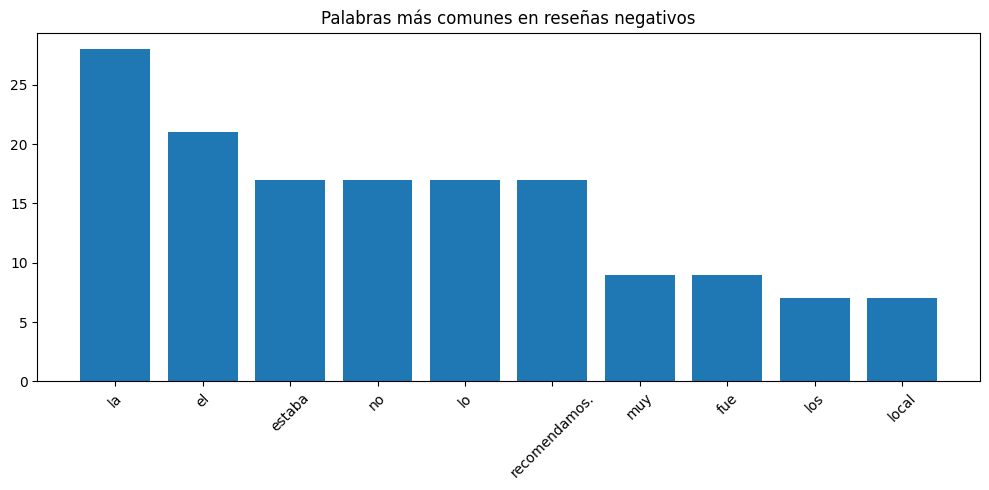

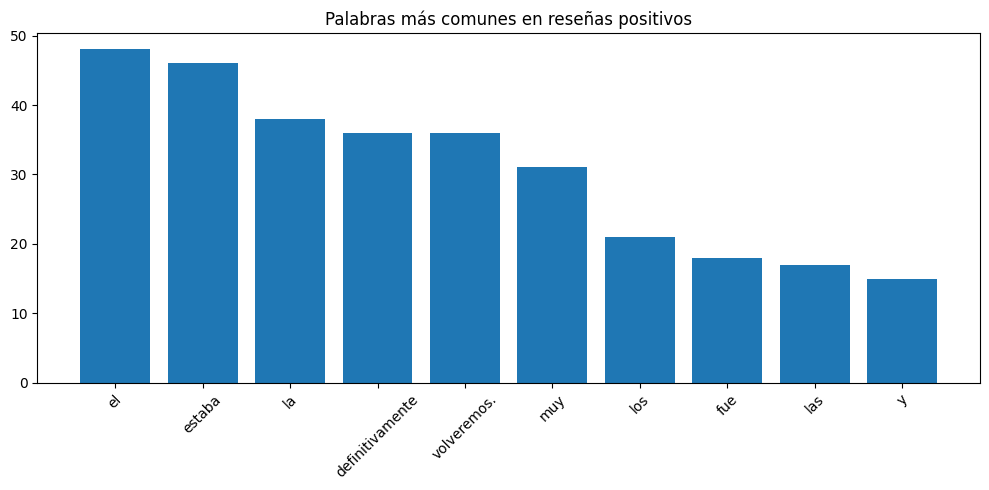

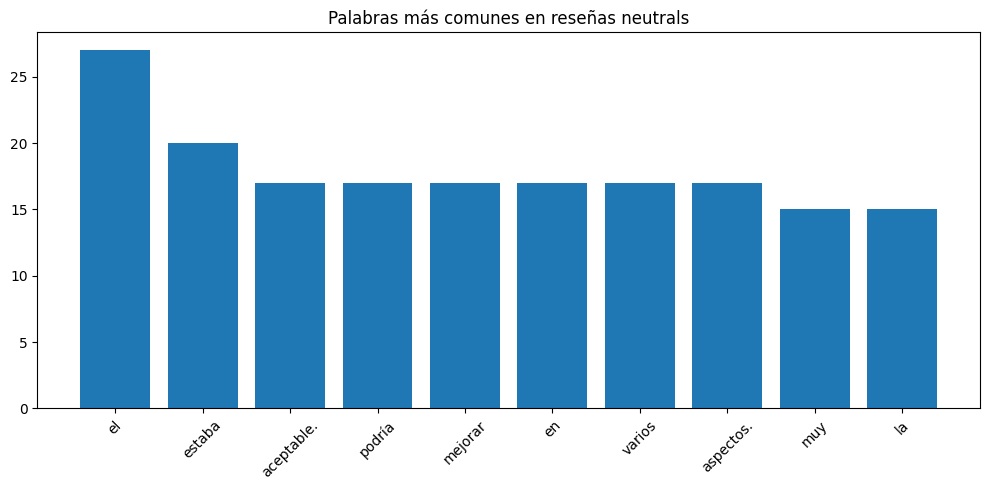

In [50]:
def visualizar_palabras_caracteristicas(conteos, categoria, n=10):
    """
    Visualiza las palabras más características de una categoría
    """
    palabras_comunes = conteos[categoria].most_common(n)
    palabras, frecuencias = zip(*palabras_comunes)

    plt.figure(figsize=(10, 5))
    plt.bar(palabras, frecuencias)
    plt.title(f'Palabras más comunes en reseñas {categoria}s')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualizar para cada categoría
for categoria in conteos:
    visualizar_palabras_caracteristicas(conteos, categoria)

## 8. Evaluación Simple

Precisión del modelo: 100.00%


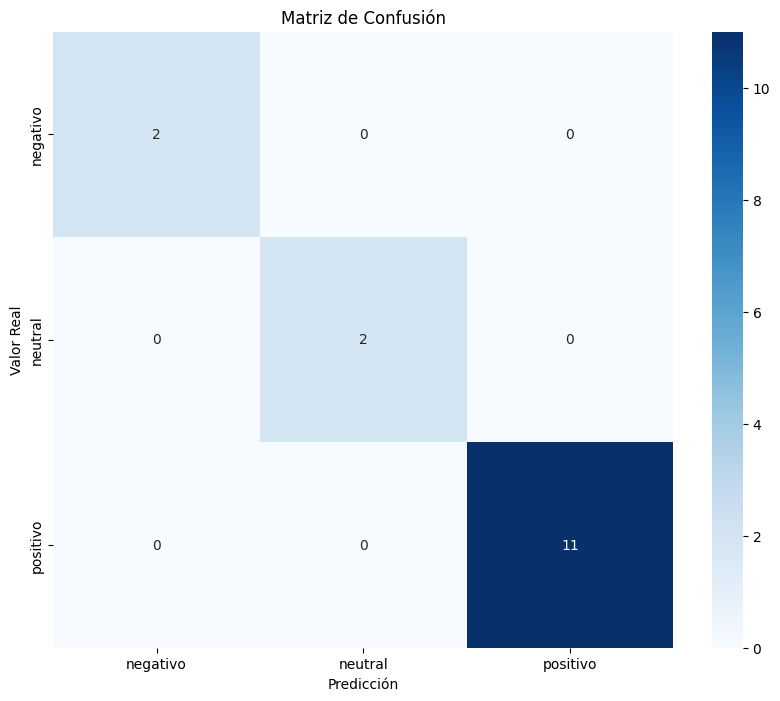


Métricas por categoría:

Categoría: negativo
Precisión: 100.00%
Recall: 100.00%
F1-Score: 100.00%

Categoría: neutral
Precisión: 100.00%
Recall: 100.00%
F1-Score: 100.00%

Categoría: positivo
Precisión: 100.00%
Recall: 100.00%
F1-Score: 100.00%


In [51]:
def evaluar_modelo(df, prob_palabras, prob_categorias):
    """
    Evalúa el modelo y genera una matriz de confusión
    """
    # Listas para almacenar predicciones y valores reales
    predicciones = []
    reales = []

    # Realizar predicciones
    for _, row in df.iterrows():
        prediccion = clasificar_texto(row['text'], prob_palabras, prob_categorias)
        predicciones.append(prediccion)
        reales.append(row['sentimiento'])

    # Calcular precisión global
    aciertos = sum(1 for p, r in zip(predicciones, reales) if p == r)
    precision = aciertos / len(df)
    print(f"Precisión del modelo: {precision:.2%}")

    # Crear matriz de confusión
    categorias = sorted(list(set(reales)))  # ['negativo', 'neutral', 'positivo']
    matriz_confusion = np.zeros((len(categorias), len(categorias)))

    # Llenar la matriz de confusión
    for real, pred in zip(reales, predicciones):
        i = categorias.index(real)
        j = categorias.index(pred)
        matriz_confusion[i][j] += 1

    # Visualizar matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_confusion,
                annot=True,
                fmt='g',
                cmap='Blues',
                xticklabels=categorias,
                yticklabels=categorias)
    plt.title('Matriz de Confusión')
    plt.ylabel('Valor Real')
    plt.xlabel('Predicción')
    plt.show()

    # Calcular métricas por categoría
    print("\nMétricas por categoría:")
    for i, categoria in enumerate(categorias):
        # Verdaderos positivos
        tp = matriz_confusion[i][i]
        # Falsos positivos (suma de la columna - verdaderos positivos)
        fp = matriz_confusion[:, i].sum() - tp
        # Falsos negativos (suma de la fila - verdaderos positivos)
        fn = matriz_confusion[i, :].sum() - tp

        # Calcular precisión y recall
        precision_cat = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_cat = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision_cat * recall_cat) / (precision_cat + recall_cat) if (precision_cat + recall_cat) > 0 else 0

        print(f"\nCategoría: {categoria}")
        print(f"Precisión: {precision_cat:.2%}")
        print(f"Recall: {recall_cat:.2%}")
        print(f"F1-Score: {f1:.2%}")

# Evaluar el modelo
evaluar_modelo_detallado(test_data, prob_palabras, prob_categorias)

## 9. Reseñas Ambiguas

Para hacer el problema más realista y desafiante, podemos modificar algunas reseñas para que sean más ambiguas o contengan sentimientos mezclados. Aquí hay algunos ejemplos de reseñas que podríamos añadir al dataset:

In [53]:
reseñas_ambiguas = [
    {
        "id": 101,
        "rating": 4,
        "text": "Restaurante La Paradoja: La comida estaba fría y mal presentada, pero los sabores eran extraordinarios y el chef se disculpó personalmente. Los precios son altos pero vale la pena por la originalidad de los platos."
    },
    {
        "id": 102,
        "rating": 2,
        "text": "Bistró El Contraste: El servicio fue impecable y el local es precioso, pero la calidad de la comida fue terrible. A pesar del ambiente maravilloso, no podemos dar más que una mala valoración por lo principal: la comida."
    },
    {
        "id": 103,
        "rating": 3,
        "text": "Cafetería La Duda: Los pasteles son exquisitos y el café horrible. El personal es amable pero extremadamente lento. El local está limpio pero necesita renovación. No sé si recomendarlo o no."
    },
    {
        "id": 104,
        "rating": 5,
        "text": "Bar El Misterio: El local es pequeño y ruidoso, el servicio algo lento, pero la comida es tan espectacular que compensa todo lo demás. Los precios son excesivos aunque repetiremos sin duda."
    },
    {
        "id": 105,
        "rating": 1,
        "text": "Restaurante La Confusión: A pesar de la excelente ubicación y la decoración elegante, todo lo demás fue un desastre. Ni siquiera los precios económicos compensan la pésima experiencia."
    }
]

# Crear DataFrame con las reseñas ambiguas
df_ambiguo = pd.DataFrame(reseñas_ambiguas)

# Asegurarnos de que tiene la misma estructura que el DataFrame original
df_ambiguo['sentimiento'] = df_ambiguo['rating'].apply(simplificar_rating)

print("Distribución de ratings en reseñas ambiguas:")
print(df_ambiguo['rating'].value_counts().sort_index())
print("\nDistribución de sentimientos:")
print(df_ambiguo['sentimiento'].value_counts())

Distribución de ratings en reseñas ambiguas:
rating
1    1
2    1
3    1
4    1
5    1
Name: count, dtype: int64

Distribución de sentimientos:
sentimiento
positivo    2
negativo    2
neutral     1
Name: count, dtype: int64


## 10. Evaluar Reseñas Ambiguas


Evaluación del modelo en reseñas ambiguas:
Precisión del modelo: 60.00%


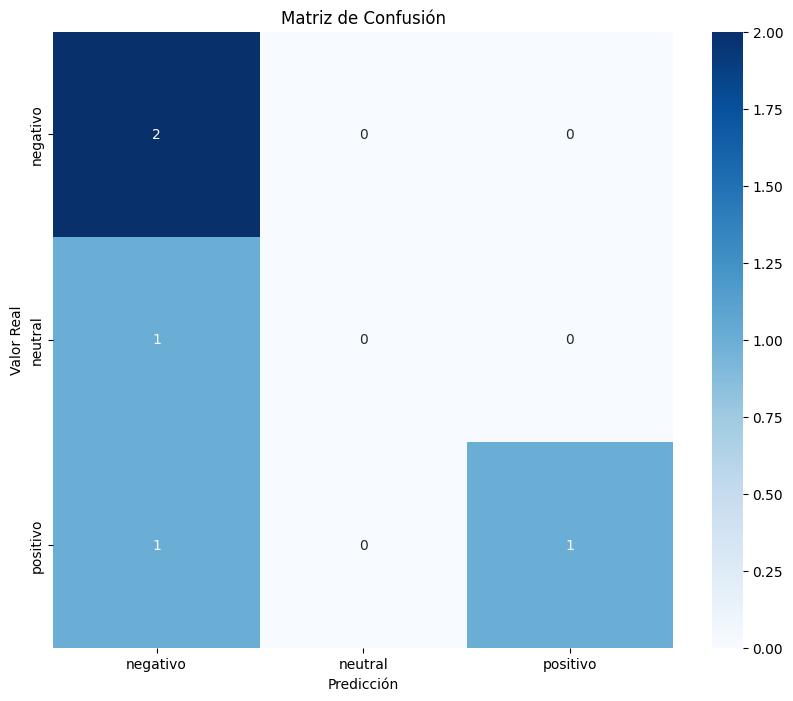


Métricas por categoría:

Categoría: negativo
Precisión: 50.00%
Recall: 100.00%
F1-Score: 66.67%

Categoría: neutral
Precisión: 0.00%
Recall: 0.00%
F1-Score: 0.00%

Categoría: positivo
Precisión: 100.00%
Recall: 50.00%
F1-Score: 66.67%


In [57]:
# Evaluar el modelo en las reseñas ambiguas
print("\nEvaluación del modelo en reseñas ambiguas:")
evaluar_modelo(df_ambiguo, prob_palabras, prob_categorias)